In [1]:
import numpy as np
from utils_clean import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import t
import plotly.graph_objects as go


pso = PSOOptim(n_iters=100, n_particles=10, c1=0.5, c2=0.3, w=0.9, visualize=False)
optim = DEOptim(maxiter=100, visualize=False)

In [2]:
noise_scales = [1, 5, 10, 30, 50, 70]
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)
n_train_data_points = 70
n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5


num_iter = 10
df_results = pd.DataFrame({ "noise scale":[], "Log Likelihood PSO":[], "Log Likelihood RS":[], "Log Likelihood DE":[]})
for noise in tqdm(noise_scales):
    for i in range(0,num_iter):
        X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func, noise_scale=noise)

        rs = RandomOptim(maxiter=1000, visualize=False, random_state=i)

        X_train, y_train = generate_sample(n_train_data_points, n_dims, lower_bound, upper_bound, target_func, noise_scale=noise)
        # pso
        gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_pso.fit(X.T, y[...,None])

        # rs
        gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_rs.fit(X.T, y[...,None])

        # de
        gpr_de = GaussianProcessRegressor(optimizer=optim.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_de.fit(X.T, y[...,None])

        df_results.loc[len(df_results)] = [noise, gpr_pso.log_marginal_likelihood_value_, gpr_rs.log_marginal_likelihood_value_, gpr_de.log_marginal_likelihood_value_]

print(df_results)

  0%|          | 0/6 [00:00<?, ?it/s]2022-08-09 15:14:41,617 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.46e+4
2022-08-09 15:14:46,366 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34611.01401405332, best pos: [-1.07712994 -1.07267716]
2022-08-09 15:14:49,772 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.46e+4
2022-08-09 15:14:55,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34611.259336613344, best pos: [-1.07407335 -1.07293256]
2022-08-09 15:14:58,825 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=3.46e+4
2022-08-09 15:15:03,109 - pyswarms.single.global_best - INFO - Optim

    noise scale  Log Likelihood PSO  Log Likelihood RS  Log Likelihood DE
0           1.0       -34611.014014      -43460.232650      -34611.012889
1           1.0       -34611.259337      -34837.489700      -34611.012889
2           1.0       -34611.050231      -37487.054003      -34611.012889
3           1.0       -34611.072137      -37802.859931      -34611.012889
4           1.0       -34611.175102      -42079.251748      -34611.012889
5           1.0       -34611.100732      -41935.578641      -34611.012889
6           1.0       -34611.054409      -41438.685549      -34611.012889
7           1.0       -34611.331066      -44238.592447      -34611.012889
8           1.0       -34612.402163      -44025.233522      -34611.012889
9           1.0       -34611.060898      -36346.711984      -34611.012889
10          5.0       -41573.274141      -51637.403311      -41573.155901
11          5.0       -41573.330694      -46456.792541      -41573.155901
12          5.0       -41573.231484   

In [3]:
df_results_ = df_results.groupby(['noise scale'], as_index=False).agg({'Log Likelihood PSO':['mean','std'], 'Log Likelihood RS':['mean','std'], 'Log Likelihood DE':['mean','std']})

df_results_["conf_95_o_pso"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood PSO"]["std"] + df_results_["Log Likelihood PSO"]["mean"]
df_results_["conf_95_u_pso"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood PSO"]["std"] + df_results_["Log Likelihood PSO"]["mean"]

df_results_["conf_95_o_rs"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood RS"]["std"] + df_results_["Log Likelihood RS"]["mean"]
df_results_["conf_95_u_rs"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood RS"]["std"] + df_results_["Log Likelihood RS"]["mean"]

df_results_["conf_95_o_de"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood DE"]["std"] + df_results_["Log Likelihood DE"]["mean"]
df_results_["conf_95_u_de"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood DE"]["std"] + df_results_["Log Likelihood DE"]["mean"]

2022-08-09 15:22:34,278 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-08-09 15:22:34,279 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


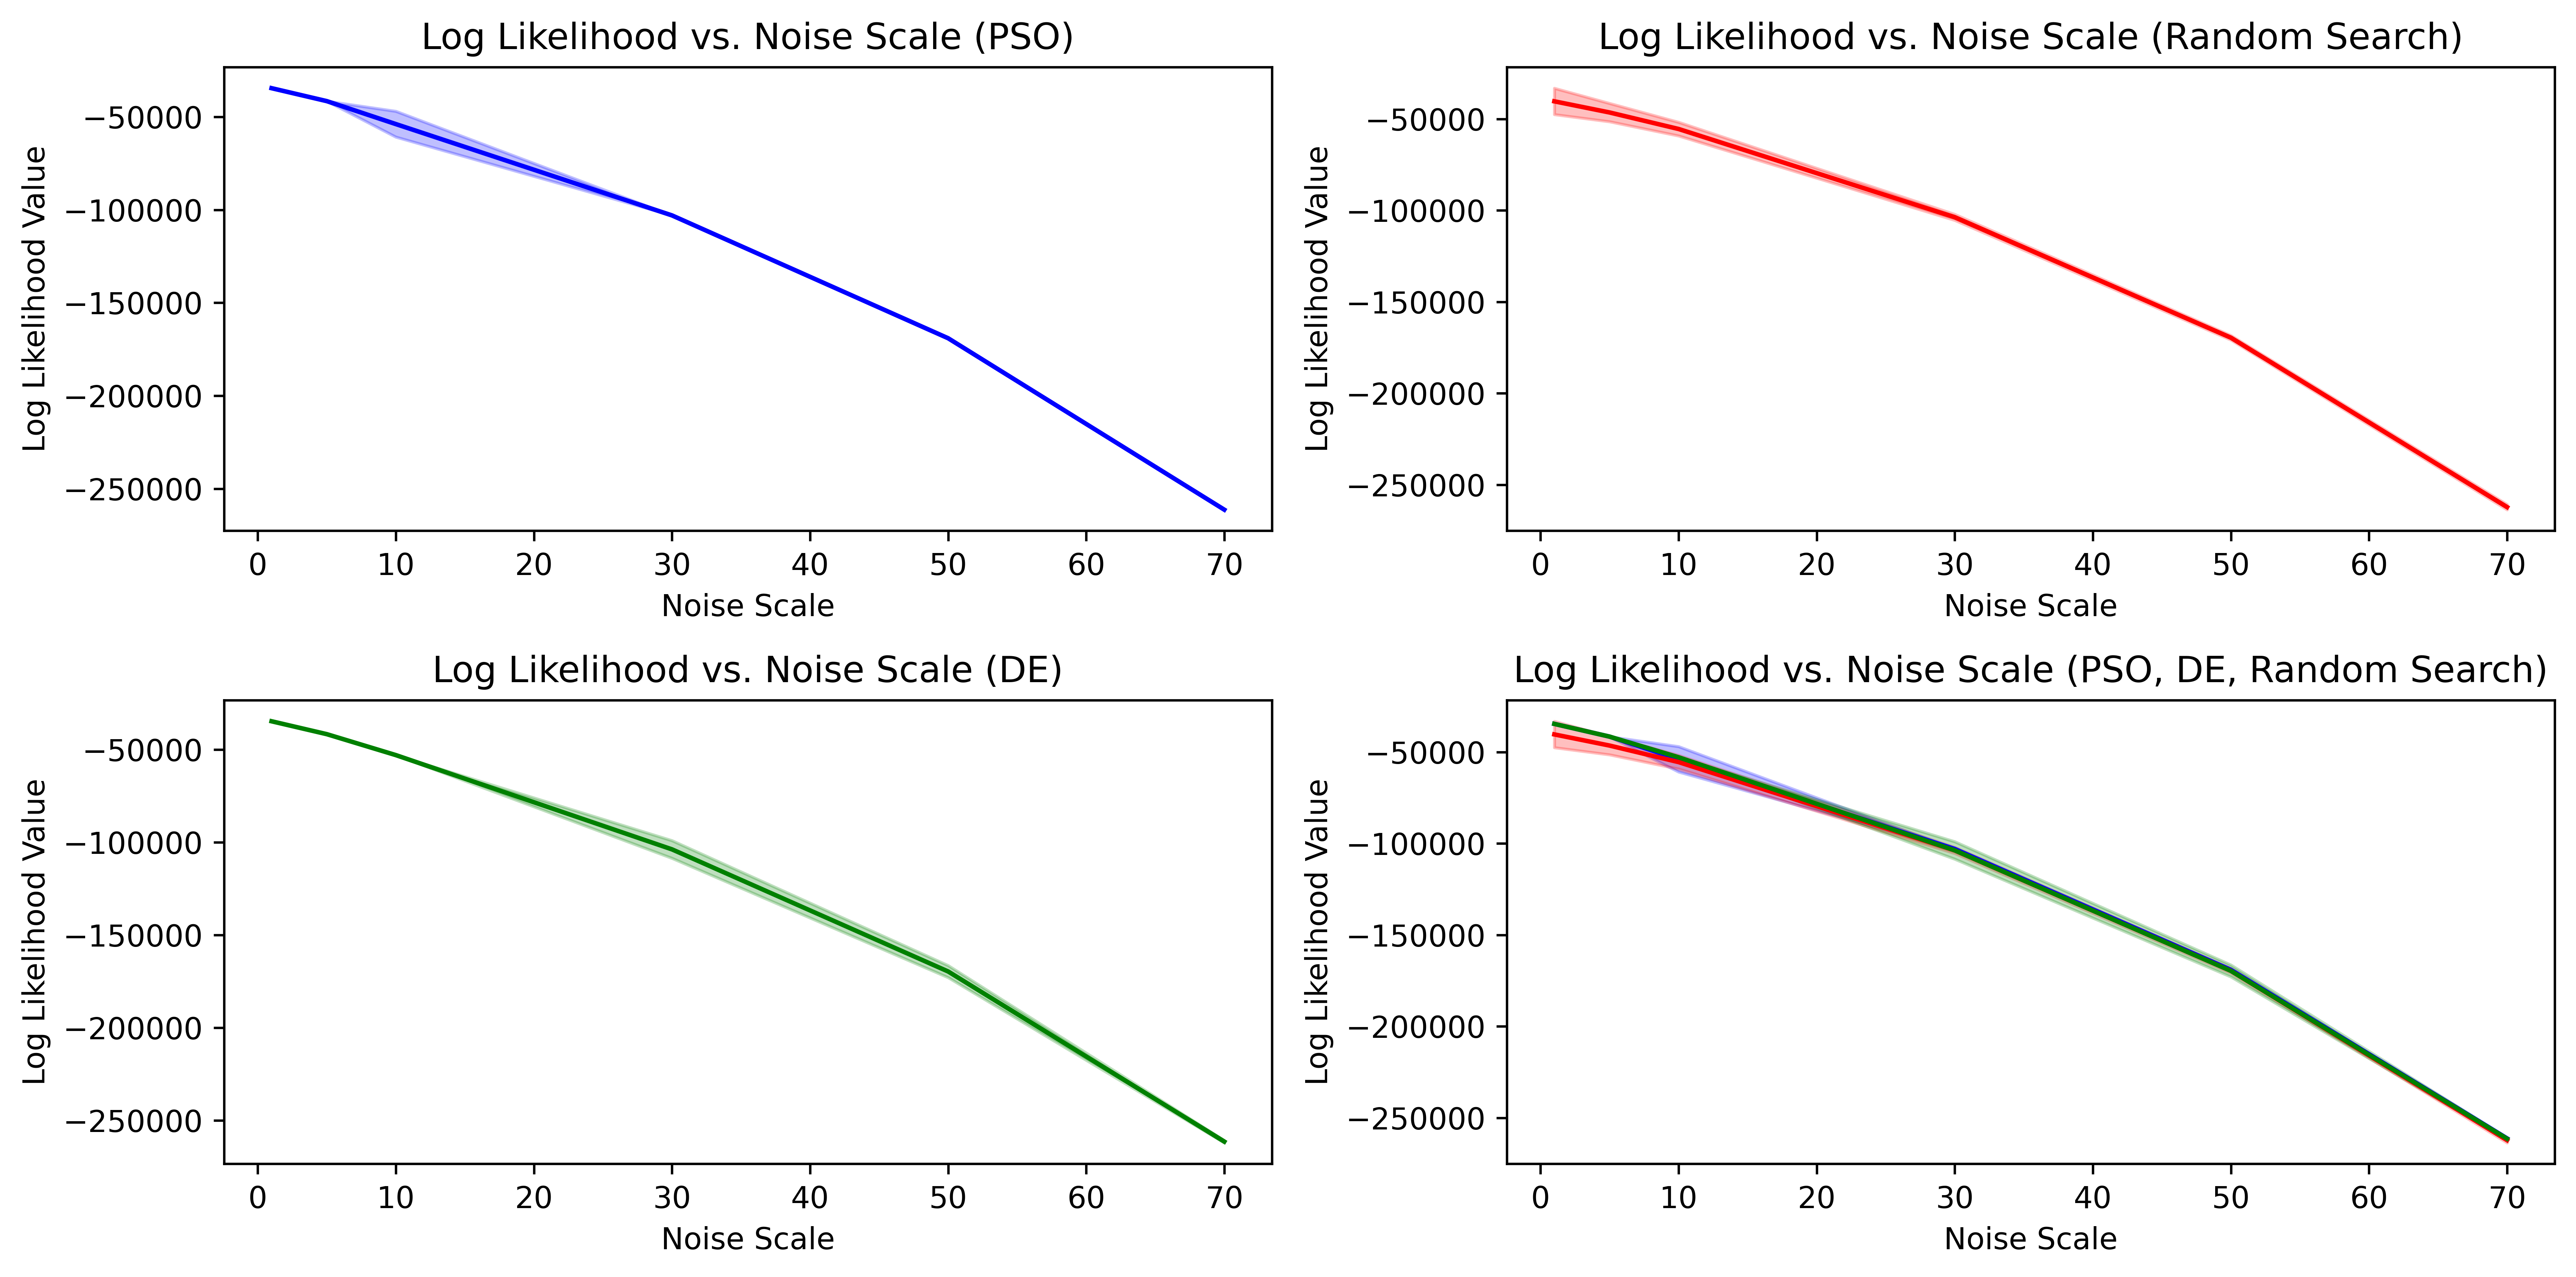

In [26]:
plt.figure(figsize=(12,6), dpi=600)
plt.subplot(221)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (PSO)")
plt.subplot(222)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"], color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"], df_results_["conf_95_o_rs"], color="r", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (Random Search)")
plt.tight_layout()

plt.subplot(223)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (DE)")
plt.subplot(224)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"], color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"], df_results_["conf_95_o_rs"], color="r", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
plt.title("Log Likelihood vs. Noise Scale (PSO, DE, Random Search)")
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.tight_layout()